<a href="https://colab.research.google.com/github/MarcFriz/Kaggle-Earthquake_challenge/blob/master/Kaggle_Earthquake_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://i.imgur.com/rTadNbm.png)

# Step 1 - Install and Import

In [3]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost
!pip install keras
!pip install xgboost

In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Step 2 - Import Dataset from Kaggle

In [5]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [6]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip train.csv.zip
!ls

catboost_info  sample_submission.csv  train.csv
sample_data    test.zip		      train.csv.zip
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
catboost_info  sample_submission.csv  train.csv
sample_data    test.zip		      train.csv.zip


# Step 3 -  Exploratory Data Analysis

In [0]:

#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [9]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


(60000,)


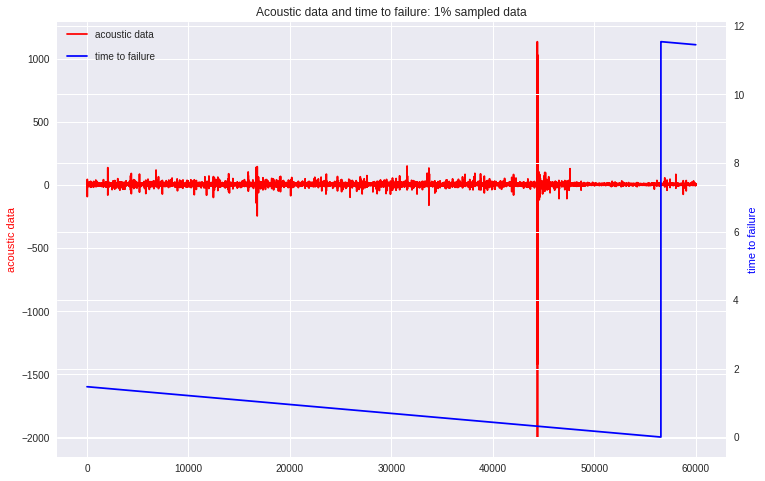

In [10]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

print(train_ad_sample_df.shape)

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# Step 4 - Feature Engineering

In [0]:
#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [13]:
X_train.describe()

,0,1,2,3,4,5,6,7,8
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,5515.000000,32.762073,150.432368


In [14]:
X_train.head()

,0,1,2,3,4,5,6,7,8
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,145.0,6.110587,6.329485


In [15]:
y_train.head()

0    1.430797
0    1.391499
0    1.353196
0    1.313798
0    1.274400
dtype: float64

# Step 5 - Implement Catboost Model

In [16]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7976107174233478}}

# Step 6 - Implement XGBoost

In [41]:
import xgboost as xgb

gbm = xgb.XGBRegressor()
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'colsample_bytree': [1.0], 'min_child_weight': [1.0, 1.2], 'max_depth': [3, 4, 6], 'n_estimators': [500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [68]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'n_estimators': 500}

In [69]:
gbm = xgb.XGBRegressor(**reg_cv.best_params_)
gbm.fit(X_train,y_train, eval_metric='mae')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1.0, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [70]:
gbm.score(X_train,y_train)

0.6715810910633914

In [71]:
from sklearn import metrics

metrics.mean_absolute_error(y_train, gbm.predict(X_train))

1.641375677361558

# Step 7 - Implement LSTM

In [18]:
X_train.head()

,0,1,2,3,4,5,6,7,8
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,145.0,6.110587,6.329485


In [19]:
print(X_train.size)
new = X_train[:-95]
print(new.size)
s = new.as_matrix()
s = s.reshape(41, 100, 9)
s.shape

37755
36900


(41, 100, 9)

In [20]:
d = y_train[:-95]
d = d.reshape(41,100)
d.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


(41, 100)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import losses

import keras

Using TensorFlow backend.


In [95]:
lstm_out = 200

model = Sequential()
model.add(LSTM(lstm_out, input_shape=(100,9), dropout_U = 0.002, dropout_W = 0.002, return_sequences=False))
# model.add(LSTM(lstm_out, input_shape=(100,9), dropout_U = 0.002, dropout_W = 0.002))
model.add(Dense(100,activation='relu'))
adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.mean_absolute_error , optimizer=adam, metrics = ['mae', 'acc'])
print(model.summary())

model.fit(s, d, nb_epoch = 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, input_shape=(100, 9), return_sequences=False, dropout=0.002, recurrent_dropout=0.002)`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 200)               168000    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
Total params: 188,100
Trainable params: 188,100
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/1000
41/41 [==============================] - 4s 96ms/step - loss: 5.4412 - mean_absolute_error: 5.4412 - acc: 0.0000e+00
Epoch 2/1000
41/41 [==============================] - 0s 11ms/step - loss: 5.0276 - mean_absolute_error: 5.0276 - acc: 0.0244
Epoch 3/1000
41/41 [==============================] - 0s 11ms/step - loss: 4.5793 - mean_absolute_error: 4.5793 - acc: 0.0000e+00
Epoch 4/1000
41/41 [==============================] - 0s 11ms/step - loss: 4.1811 - mean_absolute_error: 4.1811 - acc: 0.0000e+00
Epoch 5/1000
41/41 [==============================] - 0s 11ms/step - loss: 3.9057 - mean_absolute_error: 3.9057 - acc: 0.0000e+00
Epoch 6/1000
41/41 [==============================] - 0s 11ms/step - loss: 3.7202 - mean_absolute_error: 3.7202 - acc: 0.0000e+00
Epoch 7/1000
41/41 [==============================] - 0s 11ms/step - loss: 3.6422 - mean_absolute_error: 3.6422 - acc: 0.0000e+00
Epoch 8/1000
41/41 [==============================] - 0s 10ms/step - loss: 3.5816 - mean_absol

In [96]:
metrics.mean_absolute_error(d, model.predict(s))

1.9952167647589478